In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score


In [3]:
# Paths
train_dir = '/kaggle/input/fer2013plus/fer2013plus/fer2013/train'
test_dir = '/kaggle/input/fer2013plus/fer2013plus/fer2013/test'

# Image properties
img_size = (48, 48)
batch_size = 64

# Image augmentation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.
Found 7099 images belonging to 8 classes.


In [4]:
print("Train samples:", train_generator.samples)
print("Validation samples:", val_generator.samples)
print("Test samples:", test_generator.samples)


Train samples: 22712
Validation samples: 5674
Test samples: 7099


In [8]:
# Define Traditional CNN Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define the model
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 46, 46, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,422,344 (5.43 MB)

 Trainable params: 1,421,448 (5.42 MB)

 Non-trainable params: 896 (3.50 KB)

In [10]:
#Train Model (30 Epochs)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

checkpoint_keras = ModelCheckpoint("best_model_tradCNN.keras", monitor="val_accuracy", save_best_only=True, verbose=1)

checkpoint_h5 = ModelCheckpoint("best_model_tradCNN.weights.h5", monitor="val_accuracy", save_best_only=True, save_weights_only=True, verbose=1)

# Fit model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # Increased to allow learning but with early stopping
    callbacks=[early_stop, reduce_lr, checkpoint_keras, checkpoint_h5]
)

Epoch 1/30
348/355 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3594 - loss: 1.6673
Epoch 1: val_accuracy improved from -inf to 0.38016, saving model to best_model_tradCNN.keras

Epoch 1: val_accuracy improved from -inf to 0.38016, saving model to best_model_tradCNN.weights.h5
355/355 ━━━━━━━━━━━━━━━━━━━━ 51s 143ms/step - accuracy: 0.3597 - loss: 1.6667 - val_accuracy: 0.3802 - val_loss: 2.1966 - learning_rate: 1.0000e-04
Epoch 2/30
348/355 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4123 - loss: 1.5828
Epoch 2: val_accuracy improved from 0.38016 to 0.48713, saving model to best_model_tradCNN.keras

Epoch 2: val_accuracy improved from 0.38016 to 0.48713, saving model to best_model_tradCNN.weights.h5
355/355 ━━━━━━━━━━━━━━━━━━━━ 27s 74ms/step - accuracy: 0.4125 - loss: 1.5824 - val_accuracy: 0.4871 - val_loss: 1.5721 - learning_rate: 1.0000e-04
Epoch 3/30
348/355 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4531 - loss: 1.5066
Epoch 3: val_accuracy improved from 0.48713 to 0.5

In [11]:
# Validation accuracy
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Test accuracy
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.7142 - loss: 0.8192
Validation Accuracy: 71.70%
7099/7099 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - accuracy: 0.6708 - loss: 0.9885
Test Accuracy: 72.15%


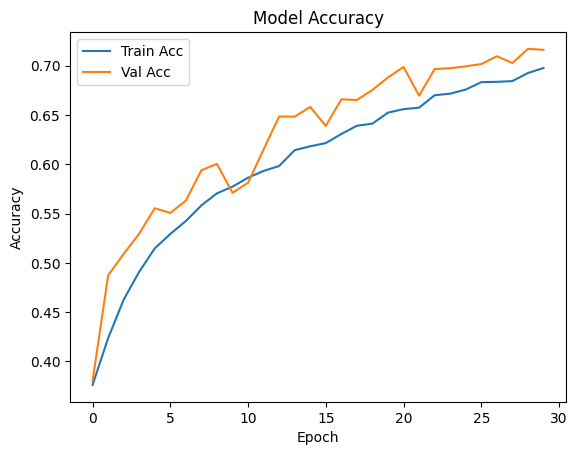

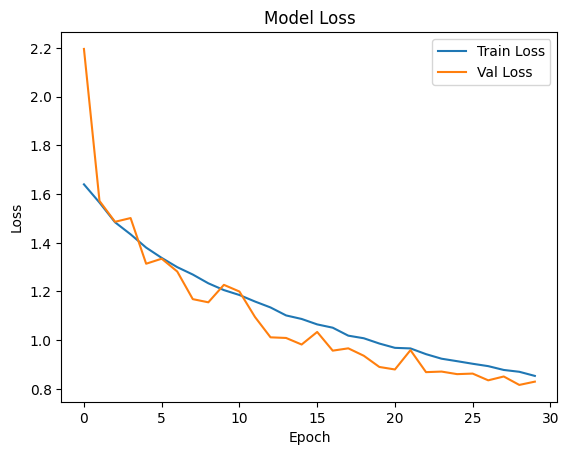

In [12]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [13]:
model.save('emotion_model_tradCNN_V2.h5')
print("Model saved as emotion_model.h5")


Model saved as emotion_model.h5


Image Path: /kaggle/input/fer2013plus/fer2013plus/fer2013/test/anger/fer0028729.png
Does the image exist? True
Original image shape: (48, 48)
Input shape for model: (1, 48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
Raw prediction output: [[2.7370730e-01 2.7106598e-04 4.1982681e-03 6.7838356e-02 1.5769921e-01
  1.0965429e-02 2.8825982e-02 4.5649436e-01]]
Predicted Emotion: surprise


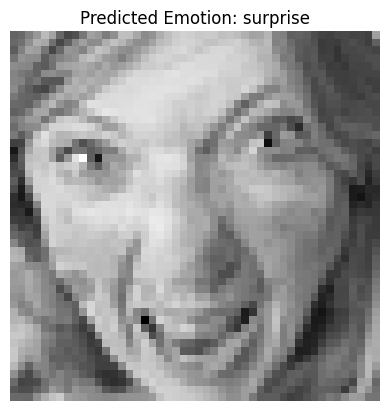

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Set image size expected by your model
img_size = (48, 48)

# Load your trained model (update path if needed)
# model = load_model('your_model_path.h5')

# Load class labels from your training generator
class_labels = list(train_generator.class_indices.keys())

# Image path
image_path = '/kaggle/input/fer2013plus/fer2013plus/fer2013/test/anger/fer0028729.png'

# Confirm path
print(f"Image Path: {image_path}")
print(f"Does the image exist? {os.path.exists(image_path)}")

def predict_emotion(image_path):
    # Step 1: Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not load image.")
        return
    
    print(f"Original image shape: {img.shape}")
    
    # Step 2: Resize image
    img = cv2.resize(img, img_size)
    
    # Step 3: Normalize and reshape
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)  # (48, 48, 1)
    img = np.expand_dims(img, axis=0)   # (1, 48, 48, 1)
    
    print(f"Input shape for model: {img.shape}")
    
    # Step 4: Predict emotion
    prediction = model.predict(img)
    print(f"Raw prediction output: {prediction}")
    
    predicted_label = np.argmax(prediction)
    emotion = class_labels[predicted_label]
    
    print(f"Predicted Emotion: {emotion}")
    
    # Step 5: Display image
    plt.imshow(img[0, :, :, 0], cmap='gray')
    plt.title(f"Predicted Emotion: {emotion}")
    plt.axis('off')
    plt.show()

# Call the function
predict_emotion(image_path)


Image Path: /kaggle/input/fer2013plus/fer2013plus/fer2013/test/happiness/fer0028685.png
Does the image exist? True
Original image shape: (48, 48)
Input shape for model: (1, 48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Raw prediction output: [[4.7689644e-03 2.8258492e-04 5.2779866e-04 1.8729512e-03 9.2682678e-01
  5.0616875e-02 4.1954597e-03 1.0908588e-02]]
Predicted Emotion: happiness


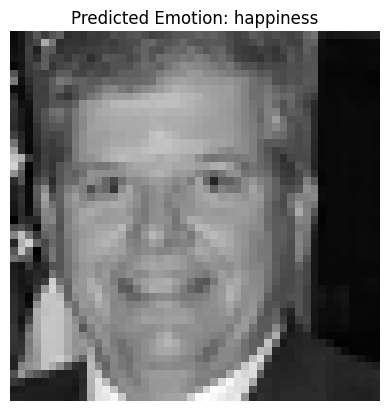

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Set image size expected by your model
img_size = (48, 48)

# Load your trained model (update path if needed)
# model = load_model('your_model_path.h5')

# Load class labels from your training generator
class_labels = list(train_generator.class_indices.keys())

# Image path
image_path = '/kaggle/input/fer2013plus/fer2013plus/fer2013/test/happiness/fer0028685.png'

# Confirm path
print(f"Image Path: {image_path}")
print(f"Does the image exist? {os.path.exists(image_path)}")

def predict_emotion(image_path):
    # Step 1: Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not load image.")
        return
    
    print(f"Original image shape: {img.shape}")
    
    # Step 2: Resize image
    img = cv2.resize(img, img_size)
    
    # Step 3: Normalize and reshape
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)  # (48, 48, 1)
    img = np.expand_dims(img, axis=0)   # (1, 48, 48, 1)
    
    print(f"Input shape for model: {img.shape}")
    
    # Step 4: Predict emotion
    prediction = model.predict(img)
    print(f"Raw prediction output: {prediction}")
    
    predicted_label = np.argmax(prediction)
    emotion = class_labels[predicted_label]
    
    print(f"Predicted Emotion: {emotion}")
    
    # Step 5: Display image
    plt.imshow(img[0, :, :, 0], cmap='gray')
    plt.title(f"Predicted Emotion: {emotion}")
    plt.axis('off')
    plt.show()

# Call the function
predict_emotion(image_path)


Image Path: /kaggle/input/fer2013plus/fer2013plus/fer2013/test/disgust/fer0029966.png
Does the image exist? True
Original image shape: (48, 48)
Input shape for model: (1, 48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Raw prediction output: [[0.03836051 0.00709007 0.00169121 0.00085464 0.00725719 0.7921532
  0.14889106 0.00370218]]
Predicted Emotion: neutral


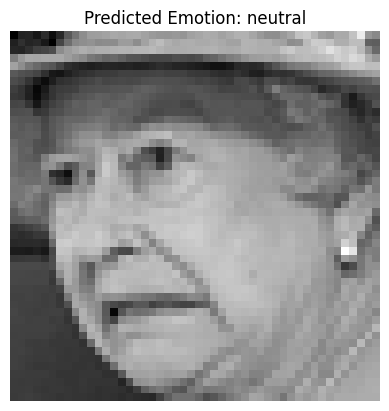

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Set image size expected by your model
img_size = (48, 48)

# Load your trained model (update path if needed)
# model = load_model('your_model_path.h5')

# Load class labels from your training generator
class_labels = list(train_generator.class_indices.keys())

# Image path
image_path = '/kaggle/input/fer2013plus/fer2013plus/fer2013/test/disgust/fer0029966.png'

# Confirm path
print(f"Image Path: {image_path}")
print(f"Does the image exist? {os.path.exists(image_path)}")

def predict_emotion(image_path):
    # Step 1: Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not load image.")
        return
    
    print(f"Original image shape: {img.shape}")
    
    # Step 2: Resize image
    img = cv2.resize(img, img_size)
    
    # Step 3: Normalize and reshape
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)  # (48, 48, 1)
    img = np.expand_dims(img, axis=0)   # (1, 48, 48, 1)
    
    print(f"Input shape for model: {img.shape}")
    
    # Step 4: Predict emotion
    prediction = model.predict(img)
    print(f"Raw prediction output: {prediction}")
    
    predicted_label = np.argmax(prediction)
    emotion = class_labels[predicted_label]
    
    print(f"Predicted Emotion: {emotion}")
    
    # Step 5: Display image
    plt.imshow(img[0, :, :, 0], cmap='gray')
    plt.title(f"Predicted Emotion: {emotion}")
    plt.axis('off')
    plt.show()

# Call the function
predict_emotion(image_path)
